In [1]:
from pyspark.sql.functions import *

In [2]:
data = spark.read.csv('/project2/macs30123/AWS_book_reviews/*.csv',
                      header='true',
                      inferSchema='true')

In [3]:
data = (data.withColumn('star_rating', col('star_rating').cast('int'))
            .withColumn('total_votes', col('total_votes').cast('int'))
            .withColumn('helpful_votes', col('helpful_votes').cast('int'))
       )
data.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- year: string (nullable = true)



In [4]:
## sample data for faster visualizations
data = data.sample(fraction = 0.001, seed=42)

## Exploratory Data Analysis

### Star Rating

In [7]:
ratings = data.groupBy('star_rating').count().toPandas()

In [10]:
ratings = ratings.drop([0,5])

In [14]:
ratings

,star_rating,count
1,1.0,1111492
2,3.0,1542787
3,5.0,13653257
4,4.0,3544383
6,2.0,861453
7,0.0,18


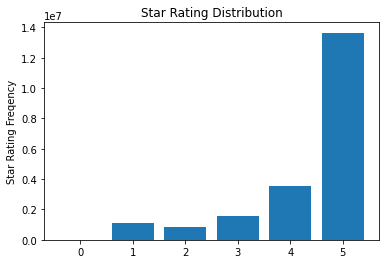

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.close('all')
x = ratings['star_rating'].values
y = ratings['count'].values
plt.title('Star Rating Distribution')
plt.bar(x, y)
plt.ylabel('Star Rating Freqency')
plt.xticks(x, ['1', '3','5','4','2','0']);

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

### Vine Purchases

In [25]:
vines = data.groupBy('vine').count().toPandas()

In [26]:
vines

,vine,count
0,0,5
1,5,1
2,Y,276
3,N,20182
4,1,3
5,4,3


In [27]:
vines = vines.drop([0,1,4,5])
vines

,vine,count
2,Y,276
3,N,20182


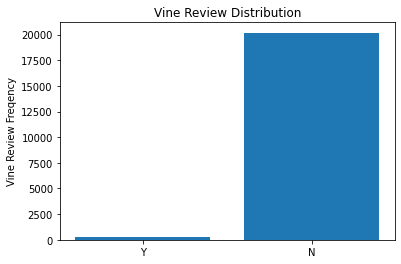

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.close('all')

x = vines['vine'].values
y = vines['count'].values
plt.title('Vine Review Distribution')
plt.bar(x, y)
plt.ylabel('Vine Review Freqency')
plt.xticks(x, ['Y', 'N']);

### Verified Purchases

In [9]:
verified = data.groupBy('verified_purchase').count().toPandas()

In [10]:
verified

,verified_purchase,count
0,0,2
1,5,1
2,Y,10417
3,N,10049
4,1,1


In [11]:
verified = verified.drop([0,1,4])

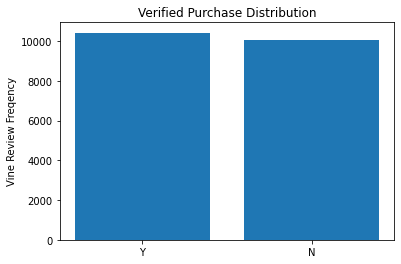

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.close('all')
x = verified['verified_purchase'].values
y = verified['count'].values
plt.title('Verified Purchase Distribution')
plt.bar(x, y)
plt.ylabel('Vine Review Freqency')
plt.xticks(x, ['Y','N']);

### Helpful? (>5 helpful votes)

In [18]:
data = data.withColumn("help_dummy", when(col("helpful_votes") >= 3, 1).otherwise(0))
helpful = data.groupBy('help_dummy').count().toPandas()

In [19]:
helpful

,help_dummy,count
0,1,5591
1,0,14879


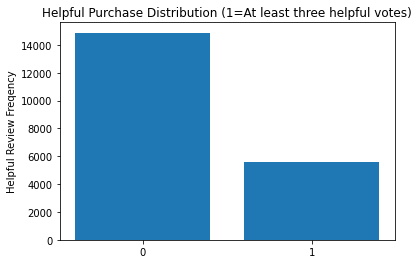

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.close('all')
x = helpful['help_dummy'].values
y = helpful['count'].values
plt.title('Helpful Purchase Distribution (1=At least three helpful votes)')
plt.bar(x, y)
plt.ylabel('Helpful Review Freqency')
plt.xticks(x, ['1','0']);

### Helpful and Verified?

In [22]:
data = data.withColumn("ver_dummy", when(col("verified_purchase") == 'Y', 1).otherwise(0))
data = data.withColumn("helpful_and_verified", when((col("ver_dummy") == 1) & (col("help_dummy") == 1), 1).otherwise(0))

In [23]:
hv = helpful = data.groupBy('helpful_and_verified').count().toPandas()
hv

,helpful_and_verified,count
0,1,1691
1,0,18779


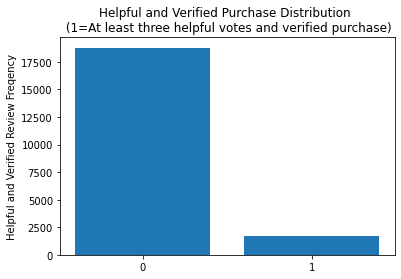

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.close('all')
x = hv['helpful_and_verified'].values
y = hv['count'].values
plt.title('Helpful and Verified Purchase Distribution \n (1=At least three helpful votes and verified purchase)')
plt.bar(x, y)
plt.ylabel('Helpful and Verified Review Freqency')
plt.xticks(x, ['1','0']);

### Length of Review and Helpfulness

In [5]:
from pyspark.sql.functions import length

data = data.withColumn('length_rev', length(col('review_body')))

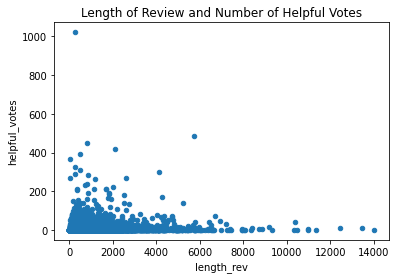

In [34]:
data_pd = data.toPandas()
data_pd.plot.scatter('length_rev', 'helpful_votes', title='Length of Review and Number of Helpful Votes');

### Length by star rating

In [7]:
stars_len = (data.groupBy('star_rating')
                   .mean('length_rev')
                   .sort('star_rating', ascending=False)
              )
stars_len.show()

+-----------+------------------+
|star_rating|   avg(length_rev)|
+-----------+------------------+
|          5|  460.432936802974|
|          4| 670.5850849409733|
|          3| 652.4406999351912|
|          2| 627.2277456647399|
|          1|   527.73735581189|
|       null|15.916666666666666|
+-----------+------------------+



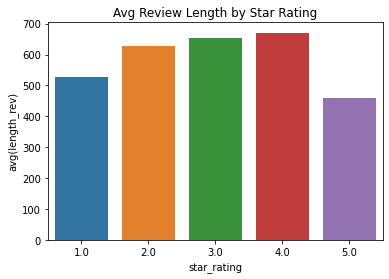

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

df = stars_len.toPandas()

# Close previous plots; otherwise, will just overwrite and display again
plt.close()

sns.barplot(x='star_rating', y='avg(length_rev)', data=df).set(title='Avg Review Length by Star Rating');

### Avg helpful votes by star rating

In [10]:
stars_help = (data.groupBy('star_rating')
                   .mean('helpful_votes')
                   .sort('star_rating', ascending=False)
              )
stars_help.show()

+-----------+------------------+
|star_rating|avg(helpful_votes)|
+-----------+------------------+
|          5| 3.317472118959108|
|          4|3.2456089835876765|
|          3|4.4361633182112765|
|          2| 6.553757225433526|
|          1| 8.884649511978704|
|       null|              4.75|
+-----------+------------------+



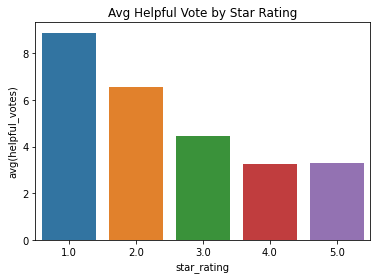

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df = stars_help.toPandas()

# Close previous plots; otherwise, will just overwrite and display again
plt.close()

sns.barplot(x='star_rating', y='avg(helpful_votes)', data=df).set(title='Avg Helpful Vote by Star Rating');